## Advanced RAG - Retrieval Strategies
### Dense, Sparse, Hybrid, and Reranking

**Learning Objectives:**
- Understand different retrieval modes
- Implement hybrid search with filters
- Apply reranking for better results
- Build reusable retrieval functions

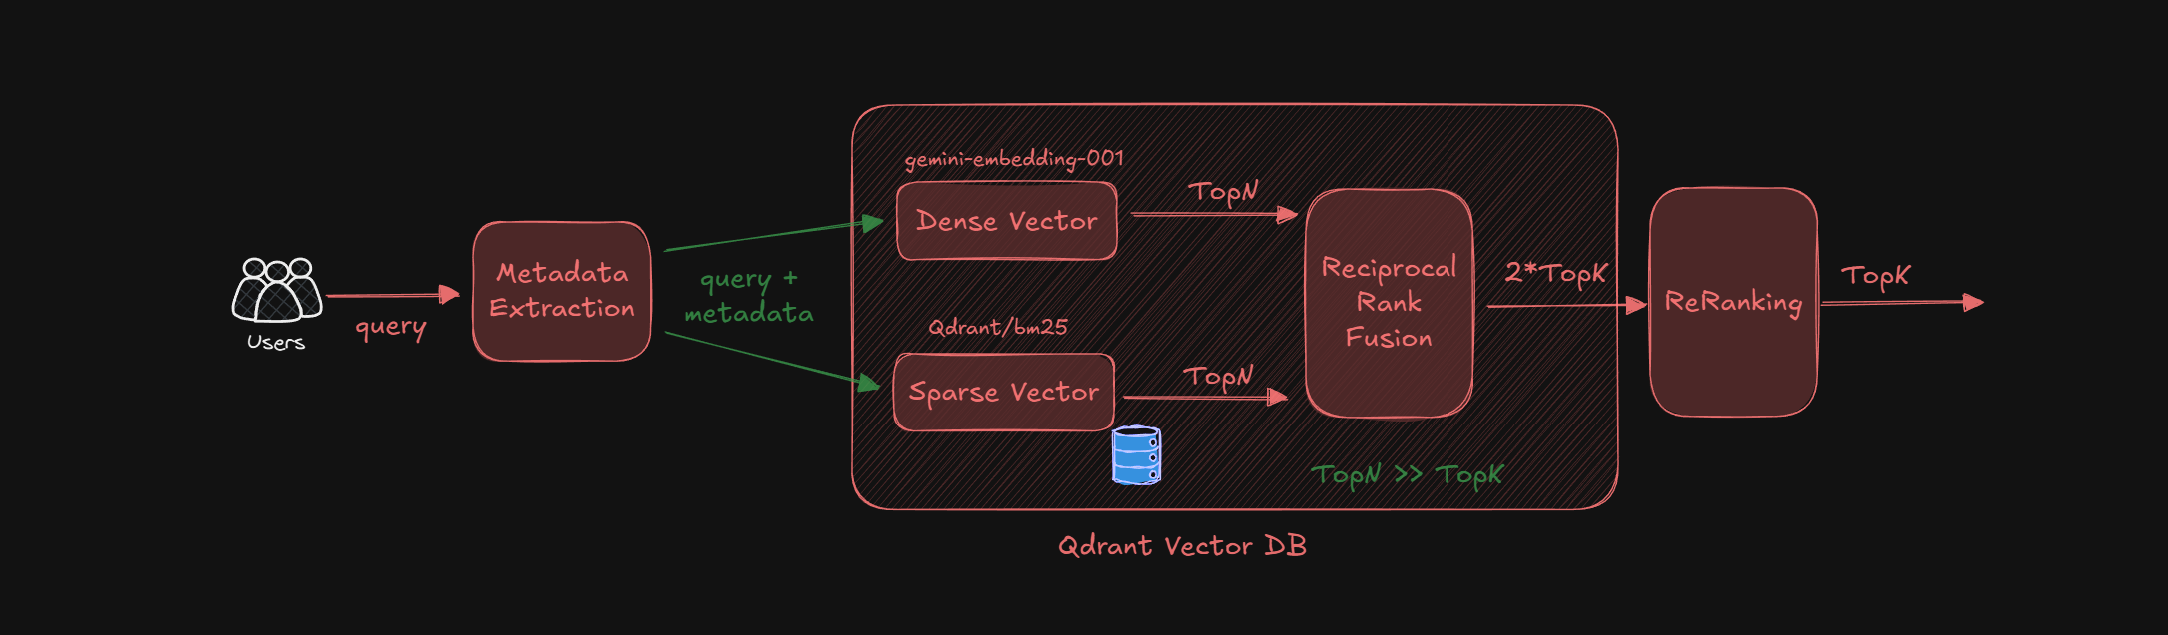
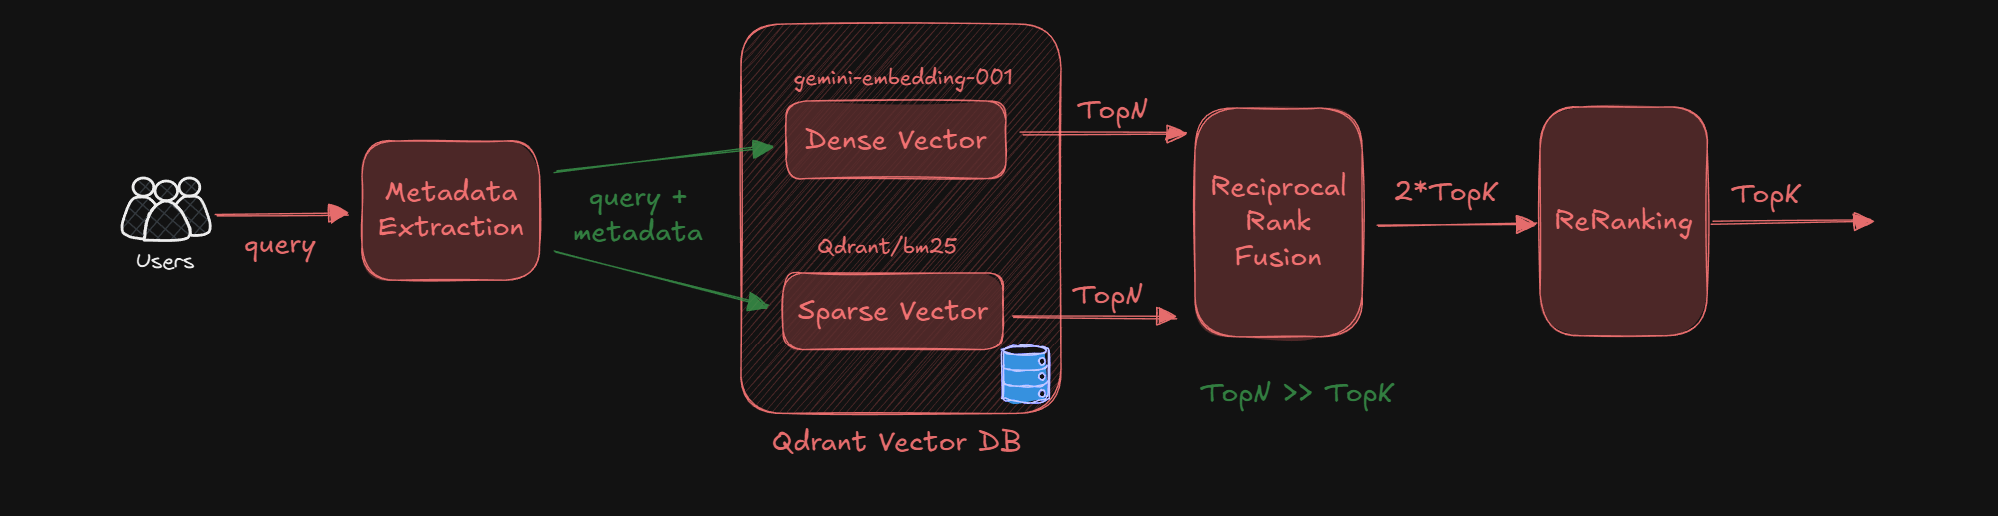
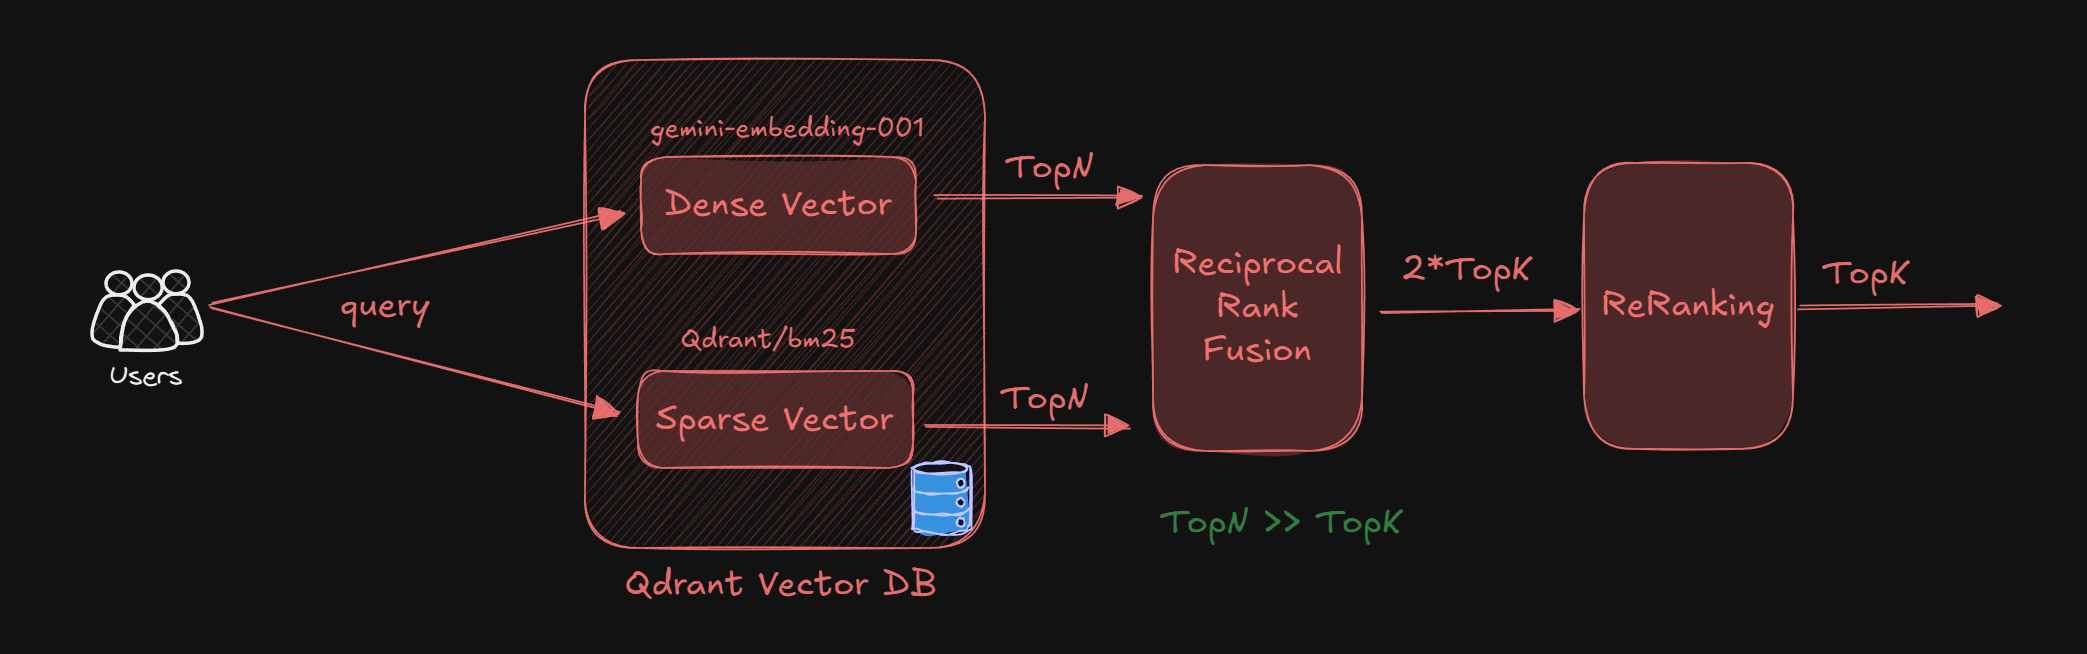

In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_qdrant import QdrantVectorStore, RetrievalMode, FastEmbedSparse

# re-ranking for better result
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# metadata filtering
from qdrant_client.models import Filter, FieldCondition, MatchValue

# metadata extraction from LLM
from scripts.schema import ChunkMetadata

In [2]:
# Configuration
COLLECTION_NAME = "financial_docs"
EMBEDDING_MODEL = "models/gemini-embedding-001"
LLM_MODEL = "gemini-2.5-flash"

RERANKER_MODEL = "BAAI/bge-reranker-base"

### Initialize LLM and Vector Store

In [3]:
# Initialize LLM
llm = ChatGoogleGenerativeAI(model=LLM_MODEL)

# Gemini embeddings
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)

# Sparse embeddings
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# Connect to existing collection
vector_store = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    collection_name=COLLECTION_NAME,
    url="http://localhost:6333",
    retrieval_mode=RetrievalMode.HYBRID
)

In [4]:
vector_store.client.get_collection(collection_name=COLLECTION_NAME)

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, warnings=None, indexed_vectors_count=2867, points_count=2878, segments_count=8, config=CollectionConfig(params=CollectionParams(vectors={'': VectorParams(size=3072, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors={'langchain-sparse': SparseVectorParams(index=None, modifier=None)}), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None, inline_storage=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optim

### Filter Extraction with LLM

In [5]:
def extract_filters(user_query: str):

    prompt = f"""
            Extract metadata filters from the query. Return None for fields not mentioned.

                <USER QUERY STARTS>
                {user_query}
                </USER QUERY ENDS>

                #### EXAMPLES
                COMPANY MAPPINGS:
                - Amazon/AMZN -> amazon
                - Google/Alphabet/GOOGL/GOOG -> google
                - Apple/AAPL -> apple
                - Microsoft/MSFT -> microsoft
                - Tesla/TSLA -> tesla
                - Nvidia/NVDA -> nvidia
                - Meta/Facebook/FB -> meta

                DOC TYPE:
                - Annual report -> 10-k
                - Quarterly report -> 10-q
                - Current report -> 8-k

                EXAMPLES:
                "Amazon Q3 2024 revenue" -> {{"company_name": "amazon", "doc_type": "10-q", "fiscal_year": 2024, "fiscal_quarter": "q3"}}
                "Apple 2023 annual report" -> {{"company_name": "apple", "doc_type": "10-k", "fiscal_year": 2023}}
                "Tesla profitability" -> {{"company_name": "tesla"}}

                Extract metadata based on the user query only:
            """
    
    structurerd_llm = llm.with_structured_output(ChunkMetadata)

    metadata = structurerd_llm.invoke(prompt)

    filters = metadata.model_dump(exclude_none=True)

    return filters
    

In [6]:
query = "what is amazon's revenue in 2023 in q1?"
filters = extract_filters(query)

In [7]:
filters

{'company_name': 'amazon',
 'doc_type': '10-q',
 'fiscal_year': '2023',
 'fiscal_quarter': 'q1'}

### Retrieval Functions

In [8]:
# metadata filtering
from qdrant_client.models import Filter, FieldCondition, MatchValue


[FieldCondition(key=f"metadata.{key}", match=MatchValue(value=value))  for key, value in filters.items()]

[FieldCondition(key='metadata.company_name', match=MatchValue(value='amazon'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None, is_empty=None, is_null=None),
 FieldCondition(key='metadata.doc_type', match=MatchValue(value='10-q'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None, is_empty=None, is_null=None),
 FieldCondition(key='metadata.fiscal_year', match=MatchValue(value='2023'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None, is_empty=None, is_null=None),
 FieldCondition(key='metadata.fiscal_quarter', match=MatchValue(value='q1'), range=None, geo_bounding_box=None, geo_radius=None, geo_polygon=None, values_count=None, is_empty=None, is_null=None)]

In [32]:
def hybrid_search(query: str, k: int = 5):
    """
    Perform hybrid search (dense + sparse vectors).
    
    Args:
        query: Search query
        k: Number of results
        filters: Optional filters like {"company_name": "amazon", "fiscal_year": 2024}
    
    Returns:
        List of Document objects
    """

    filters = extract_filters(query)

    qdrant_filter = None

    if filters:
        condition = [FieldCondition(key=f"metadata.{key}", match=MatchValue(value=value))
                     for key, value in filters.items()]
        
        qdrant_filter = Filter(must=condition)

    results = vector_store.similarity_search(query=query, k=k, filter=qdrant_filter)

    return results


In [27]:
query = "what is the tesla's revenue"

results = hybrid_search(query, k=10)

In [28]:
results

[]

In [29]:
query = "what is amazon's cashflow in 2024 in q1?"

results = hybrid_search(query, k=10)

In [30]:
results

[Document(metadata={'company_name': 'amazon', 'doc_type': '10-q', 'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'content_type': 'text', 'file_hash': 'f5878321fd0e1e417a55d0d2f32b68eb965e3b3dcf584c4e1b1b002fab265045', 'source_file': 'amazon 10-q q1 2024.md', 'page': 28, '_id': 'cabf68ab-fa10-44c4-befd-76c235d452df', '_collection_name': 'financial_docs'}, page_content="\n\ncosts, our level of productivity and accuracy, changes in volume, size, and weight of units received and fulfilled, the extent to which third-party sellers utilize Fulfillment by Amazon services, timing of fulfillment network and physical store expansion, the extent we utilize fulfillment services provided by third parties, mix of products and services sold, and our ability to affect customer service contacts per unit by implementing improvements in our operations and enhancements to our customer self-service features. Additionally, sales by our sellers have higher payment processing and related transaction costs as a

In [24]:
# re-ranking for better result
from langchain_community.cross_encoders import HuggingFaceCrossEncoder


def rerank_results(query: str, documents: list, top_k: int = 5):
    """
    Rerank documents using cross-encoder.
    
    Args:
        query: Search query
        documents: List of Document objects
        top_k: Number of top results to return
    
    Returns:
        List of (score, Document) tuples sorted by relevance
    """

    reranker = HuggingFaceCrossEncoder(model_name=RERANKER_MODEL, model_kwargs = {'device': 'cuda'})

    query_doc_pairs = [(query, doc.page_content) for doc in documents]

    scores = reranker.score(query_doc_pairs)

    reranked = sorted(zip(scores, documents), key=lambda x: x[0], reverse=True)

    reranked = reranked[:top_k]
    return [rank[1] for rank in reranked]


response = rerank_results(query, results)


In [25]:
response

[Document(metadata={'company_name': 'amazon', 'doc_type': '10-q', 'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'content_type': 'text', 'file_hash': 'f5878321fd0e1e417a55d0d2f32b68eb965e3b3dcf584c4e1b1b002fab265045', 'source_file': 'amazon 10-q q1 2024.md', 'page': 26, '_id': '92ee5e51-a0ca-4d89-9be9-91262306a587', '_collection_name': 'financial_docs'}, page_content='\n\nwere driven largely by our continued focus on price, selection, and convenience for our customers, including from our fast shipping offers. Changes in foreign exchange rates reduced International net sales by $248 million for Q1 2024.\n\nAWS sales increased 17% in Q1 2024 compared to the comparable prior year period. The sales growth primarily reflects increased customer usage, partially offset by pricing changes primarily driven by long-term customer contracts.\n\n## Operating Income (Loss)\n\nOperating income (loss) by segment is as follows (in millions):\n\n|                         | Three Months Ended March 31,  

### Example: Dynamic Filters

In [33]:
query = "what is the revenue of apple in 2024?"

results = hybrid_search(query, k=5)

In [34]:
results

[Document(metadata={'company_name': 'apple', 'doc_type': '10-k', 'fiscal_quarter': None, 'fiscal_year': '2024', 'content_type': 'text', 'file_hash': '230bdff2c0673245238fe01d46c256ca8e031f32d6e9ba5989e4dcd2a189a63d', 'source_file': 'apple 10-k 2024.md', 'page': 26, '_id': 'fd167520-62f6-4241-95b8-9eb3aa5e3c3e', '_collection_name': 'financial_docs'}, page_content='\n\n## Products and Services Performance\n\nThe following table shows net sales by category for 2024, 2023 and 2022 (dollars in millions):\n\n|                                 | 2024      | Change   | 2023      | Change   | 2022      |\n|---------------------------------|-----------|----------|-----------|----------|-----------|\n| iPhone                          | $ 201,183 | -%       | $ 200,583 | (2)%     | $ 205,489 |\n| Mac                             | 29,984    | 2%       | 29,357    | (27)%    | 40,177    |\n| iPad                            | 26,694    | (6)%     | 28,300    | (3)%     | 29,292    |\n| Wearables, Home

In [35]:
query = "what is the revenue of apple in 2023?"

results = hybrid_search(query, k=5)

results

[Document(metadata={'company_name': 'apple', 'doc_type': '10-q', 'fiscal_quarter': 'q4', 'fiscal_year': '2023', 'content_type': 'text', 'file_hash': '5262ccd5033c677ade9118ec61525bee3b0813cac91c81c367b35746b14954c9', 'source_file': 'apple 10-q q4 2023.md', 'page': 9, '_id': '7ae510cb-1e13-4c8c-bd04-d1c36b3457cd', '_collection_name': 'financial_docs'}, page_content="\n\n## Apple Inc.\n\n## Notes to Condensed Consolidated Financial Statements (Unaudited)\n\n## Note 1 - Summary of Significant Accounting Policies\n\n## Basis of Presentation and Preparation\n\nThe condensed consolidated financial statements include the accounts of Apple Inc. and its wholly owned subsidiaries (collectively 'Apple' or the 'Company'). In the opinion of the Company's management, the condensed consolidated financial statements reflect all adjustments, which are normal and recurring in nature, necessary for fair financial statement presentation. The preparation of these condensed consolidated financial statements